In [14]:
import tensorflow.keras as tk
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, MaxPool2D
from keras        import regularizers, initializers
from scipy.signal import detrend

import matplotlib.pyplot as plt
import numpy as np

In [8]:
mnist_dataset = tk.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data() 
 
# Reduce dataset size 
# train_images = train_images[:n_train] 
# train_labels = train_labels[:n_train] 
# test_images  = test_images[:n_test] 
# test_labels  = test_labels[:n_test] 
 
# Normalize pixel values within 0 and 1 
train_images = train_images / 255 
test_images  = test_images / 255

valid_frac = 0.3
N = len(train_labels)
N_valid = int(N*valid_frac)
N_train = N - N_valid

val_images = train_images[0:N_valid]
val_labels = train_labels[0:N_valid]
train_images = train_images[N_valid:]
train_labels = train_labels[N_valid:]

In [9]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


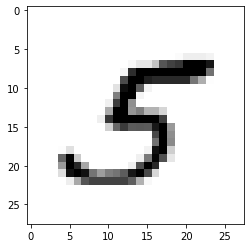

LABEL: 5


In [10]:
plot_input(train_images,train_labels,5)


In [11]:
train_images.shape

(42000, 28, 28)

In [12]:
N       = len(train_images)
n_class = len(np.unique(train_labels, return_counts=False))
input_shape = train_images.shape
type(input_shape)
input_shape = (28,28,1)
input_s = tuple(input_shape)
input_s

(28, 28, 1)

In [13]:
reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean = 0.0, stddev=0.05, seed =None)

NF = 4

model = Sequential(name="pccnn")
model.add(
    Conv2D(
        filters            = NF, 
        kernel_size        = 11, 
        kernel_initializer = ini,
        kernel_regularizer = reg,
        activation         = 'relu',
        input_shape        = input_s
    )
)
model.add(MaxPool2D(pool_size=2)) # average of 5 values
model.add(Conv2D(filters=5, kernel_size=7, activation='relu'))
model.add(Conv2D(filters=3, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_class, activation='softmax'))

print(model.summary())

opt = tf.keras.optimizers='Adam'

# compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

Model: "pccnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 4)         488       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 4)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 5)           985       
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 3)           138       
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 10)                40        
                                                             

In [ ]:
BATCH_SIZE = 250
EPOCHS     = 100

fit = model.fit(
    train_images,
    train_labels,
    batch_size      = BATCH_SIZE,
    epochs          = EPOCHS, 
    validation_data = (x_val, y_val),
    verbose         = 0, 
    shuffle         = True
)

In [ ]:
import tensorflow as tf

class NN(tf.keras.Model):
    def __init__(
        self,
        input_dim,
        architecture      = None,
        dropout_layers    = None,
        dropout_rates     = None,
        batch_norm_layers = None,
        initializer       = "glorot_uniform",
        hidden_activation = "sigmoid",
        output_activation = "sigmoid",
        nn_name           = "my neural network",
        **kwargs
    ):
        """
        Neural Network Model

        Arguments:
        input_dim         [int]    -> number of features in data               e.g. 2
        architecture      [list]   -> neural network architecture              e.g. [2, 3, 3, 1]
        dropout_layers    [list]   -> list of dropout layers                   e.g. [3, 4]
        dropout_rates     [list]   -> list of dropout rates                    e.g. [0.2, 0.5]
        batch_norm_layers [list]   -> list of batch normalization layers       e.g. [1, 2]
        initializers      [list]   -> list of weights initializers per layer   e.g. ["zeros", "ones", "glorot_uniform"]
        hidden_activation [string] -> activation function for hidden layers    e.g. relu
        output_activation [string] -> activation function for the output layer e.g. sigmoid
        name              [string] -> model name 
        """
        # initialize parent class
        super().__init__(**kwargs)

        # store the model name
        self.nn_name = nn_name

        # store the number of features 
        self.input_dim = input_dim

        # store weights initializers
        self.w_init = initializer

        # store dropout architecture
        self.dropout_arc   = dropout_layers
        self.dropout_rates = dropout_rates

        if self.dropout_arc is not None:
            self.dropout       = [ 
                tf.keras.layers.Dropout(
                    self.dropout_rates[i], 
                    name=f"dropout_{self.dropout_arc[i]-1}"
                )
                for i in range(len(self.dropout_arc))
            ]

        # store batch normalization architecture
        self.batch_norm_arc = batch_norm_layers

        if self.batch_norm_arc is not None:
            self.batch_norm     = [
                tf.keras.layers.BatchNormalization(
                    name=f"batch_norm_{self.batch_norm_arc[i]-1}"
                )
                for i in range(len(self.batch_norm_arc))
            ]

        # create the input layer with input_dim neurons
        self.input_layer = tf.keras.layers.Input(shape=self.input_dim, name="input_layer")

        self.hidden_layers = [
            tf.keras.layers.Dense(
                architecture[i+1], 
                input_shape        = (architecture[i],), 
                activation         = hidden_activation,
                kernel_initializer = self.w_init,
                name               = f"hidden_{i}"
            )
            for i in range(len(architecture)-2)
        ]

        # create hidden layers following architecture
        #if len(self.w_init) == 1:
        #    self.hidden_layers = [
        #        tf.keras.layers.Dense(
        #            architecture[i+1], 
        #            input_shape        = (architecture[i],), 
        #            activation         = hidden_activation,
        #            kernel_initializer = self.w_init[0],
        #            name               = f"hidden_{i}"
        #        )
        #        for i in range(len(architecture)-2)
        #    ]
        #elif len(self.w_init) > 1:
        #    self.hidden_layers = [
        #        tf.keras.layers.Dense(
        #            architecture[i+1], 
        #            input_shape        = (architecture[i],), 
        #            activation         = hidden_activation,
        #            kernel_initializer = self.w_init[i],
        #            name               = f"hidden_{i}"
        #        )
        #        for i in range(len(architecture)-2)
        #    ]

        # create the output layer
        self.output_layer = tf.keras.layers.Dense(
            architecture[-1], 
            input_shape = (architecture[-2],), 
            activation  = output_activation, 
            name        = "output_layer"
        )

        # build the model 
        self.build(input_shape=(None, self.input_dim))

    def call(self, x):
        """the call method deals with model creation"""

        batch_norm_counter = 0
        dropout_counter    = 0

        # for each hidden layer, feed it with the previous one
        for i, hidden_layer in enumerate(self.hidden_layers):

            # build batch normalization layer before hidden layer
            if self.batch_norm_arc is not None and (i+1) in self.batch_norm_arc:
                x = self.batch_norm[batch_norm_counter](x)
                batch_norm_counter = batch_norm_counter +1

            # build the hidden layer
            x = hidden_layer(x)

            # build dropout layer after hidden layer
            if self.dropout_arc is not None and (i+1) in self.dropout_arc:
                x = self.dropout[dropout_counter](x)
                dropout_counter = dropout_counter + 1
            
        # feed the output layer with the last hidden layer
        x = self.output_layer(x)

        # returns the computed output layer
        return x

    def summary(self):
        """re-define summary method to fix the output_shape : multiple issue"""

        # create a temporary model with all the computed shapes (thanks to self.call method)
        model = tf.keras.Model(
            inputs  = [self.input_layer], 
            outputs = self.call(self.input_layer),
            name    = self.nn_name
        )

        # return the model summary with computed shapes
        return model.summary(line_length=100)
    

def create_model(
    input_dim,
    architecture,
    dropout_layers    = None,
    dropout_rates     = None,
    batch_norm_layers = None,
    hidden_activation = "relu",
    output_activation = "sigmoid",
    initializer       = "glorot_uniform",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"],
    nn_name           = "model",
):

    # build the NN model
    model = NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_layers,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_layers,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        initializer       = initializer,
        nn_name           = nn_name,
    )
    # compile the NN model
    model.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )

    return model